<a href="https://colab.research.google.com/github/varma08/DR-Swish-GFG/blob/main/Swish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys

if 'google.colab' in str(get_ipython()):
    from google.colab import files
    files.upload()
    os.system('mkdir ~/.kaggle')
    os.system('mv ./kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')
    os.system('unzip diabetic-retinopathy-224x224-gaussian-filtered.zip')
    root_address = '.'
else:
    root_address = '../input/diabetic-retinopathy-224x224-gaussian-filtered'

Saving kaggle.json to kaggle.json


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input as mobilenet_v2_preprocess_input
from tensorflow.keras import callbacks,optimizers
from sklearn.model_selection import train_test_split

In [ ]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [ ]:
data_address = f'{root_address}/train.csv'
data = pd.read_csv(data_address)
data.head()


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


<Axes: xlabel='diagnosis', ylabel='count'>

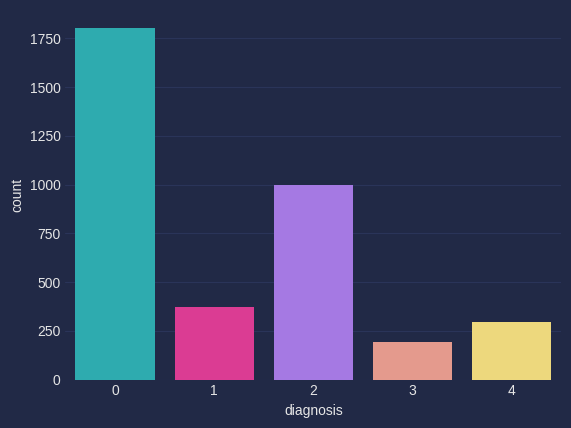

In [ ]:
sns.countplot(
    data=data, 
    x='diagnosis'
)

<Axes: xlabel='diagnosis', ylabel='count'>

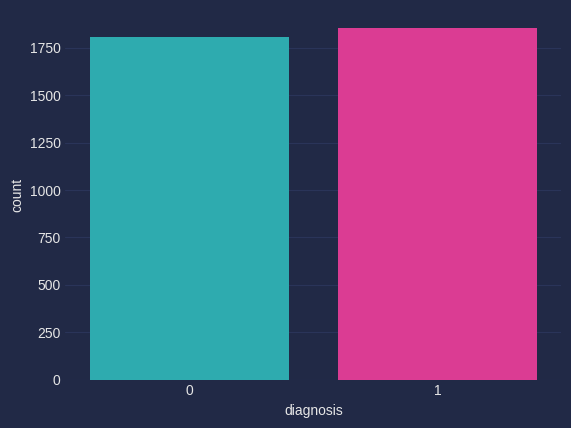

In [ ]:
data2 = data.copy()

data2['diagnosis'] = data2['diagnosis'] > 0
data2['diagnosis'] = data2['diagnosis'].astype('int32')

sns.countplot(data=data2, x='diagnosis')

In [ ]:
test_frac, val_frac = 0.25, 0.15

_, val = train_test_split(
    data, 
    test_size=val_frac, 
    stratify=data['diagnosis']
)

train, test = train_test_split(
    _, 
    test_size=test_frac/(1-val_frac),
    stratify=_['diagnosis']
)

print(f'{train.shape}, {test.shape}, {val.shape}\n')


(2196, 2), (916, 2), (550, 2)



        id_code  diagnosis status
0  000c1434d8d7          2   None
1  001639a390f0          4   None
2  0024cdab0c1e          1   None
3  002c21358ce6          0   None
4  005b95c28852          0   None 



<Axes: xlabel='status', ylabel='Percent'>

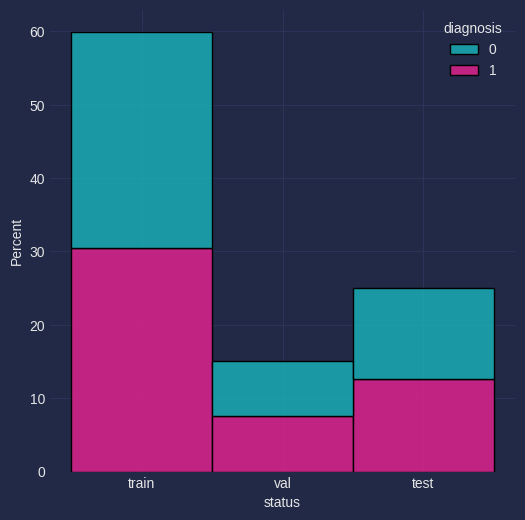

In [ ]:
data['status'] = None

for name, source in zip(['train', 'test', 'val'], [train, test, val]):
    for j in source.index:
        data2.at[j, 'status'] = name

print(data.head(), '\n')

fig = plt.subplots(figsize=(6, 6))

sns.histplot(
    data=data2, 
    x='status', 
    hue='diagnosis', 
    multiple='stack', 
    stat='percent'
)

In [ ]:
! mkdir -p data/{train,test,val}/{DR,No_DR}
! mkdir DR

! mkdir Images
for cat in ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']:
    os.system(f'cp -R {root_address}/gaussian_filtered_images/gaussian_filtered_images/{cat}/* ./Images')

! ls ./Images -1q | wc -l
! echo " files were copied"

3662
 files were copied


In [ ]:
for name, dataframe in zip(['train', 'test', 'val'], [train, test, val]):

    for filename, diag_code in zip(dataframe['id_code'], dataframe['diagnosis']):
        if diag_code:
            os.system(f'cp ./Images/{filename}.png ./data/{name}/DR/')
        else:
            os.system(f'cp ./Images/{filename}.png ./data/{name}/No_DR/')
    
    print(f'✅ {name}')

✅ train
✅ test
✅ val


In [ ]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [ ]:
train_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/train', target_size=(224, 224), shuffle = True)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/test', target_size=(224, 224), shuffle = True)
val_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.).flow_from_directory('./data/val', target_size=(224, 224), shuffle = True)

Found 2196 images belonging to 2 classes.
Found 916 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
test_data.n


916

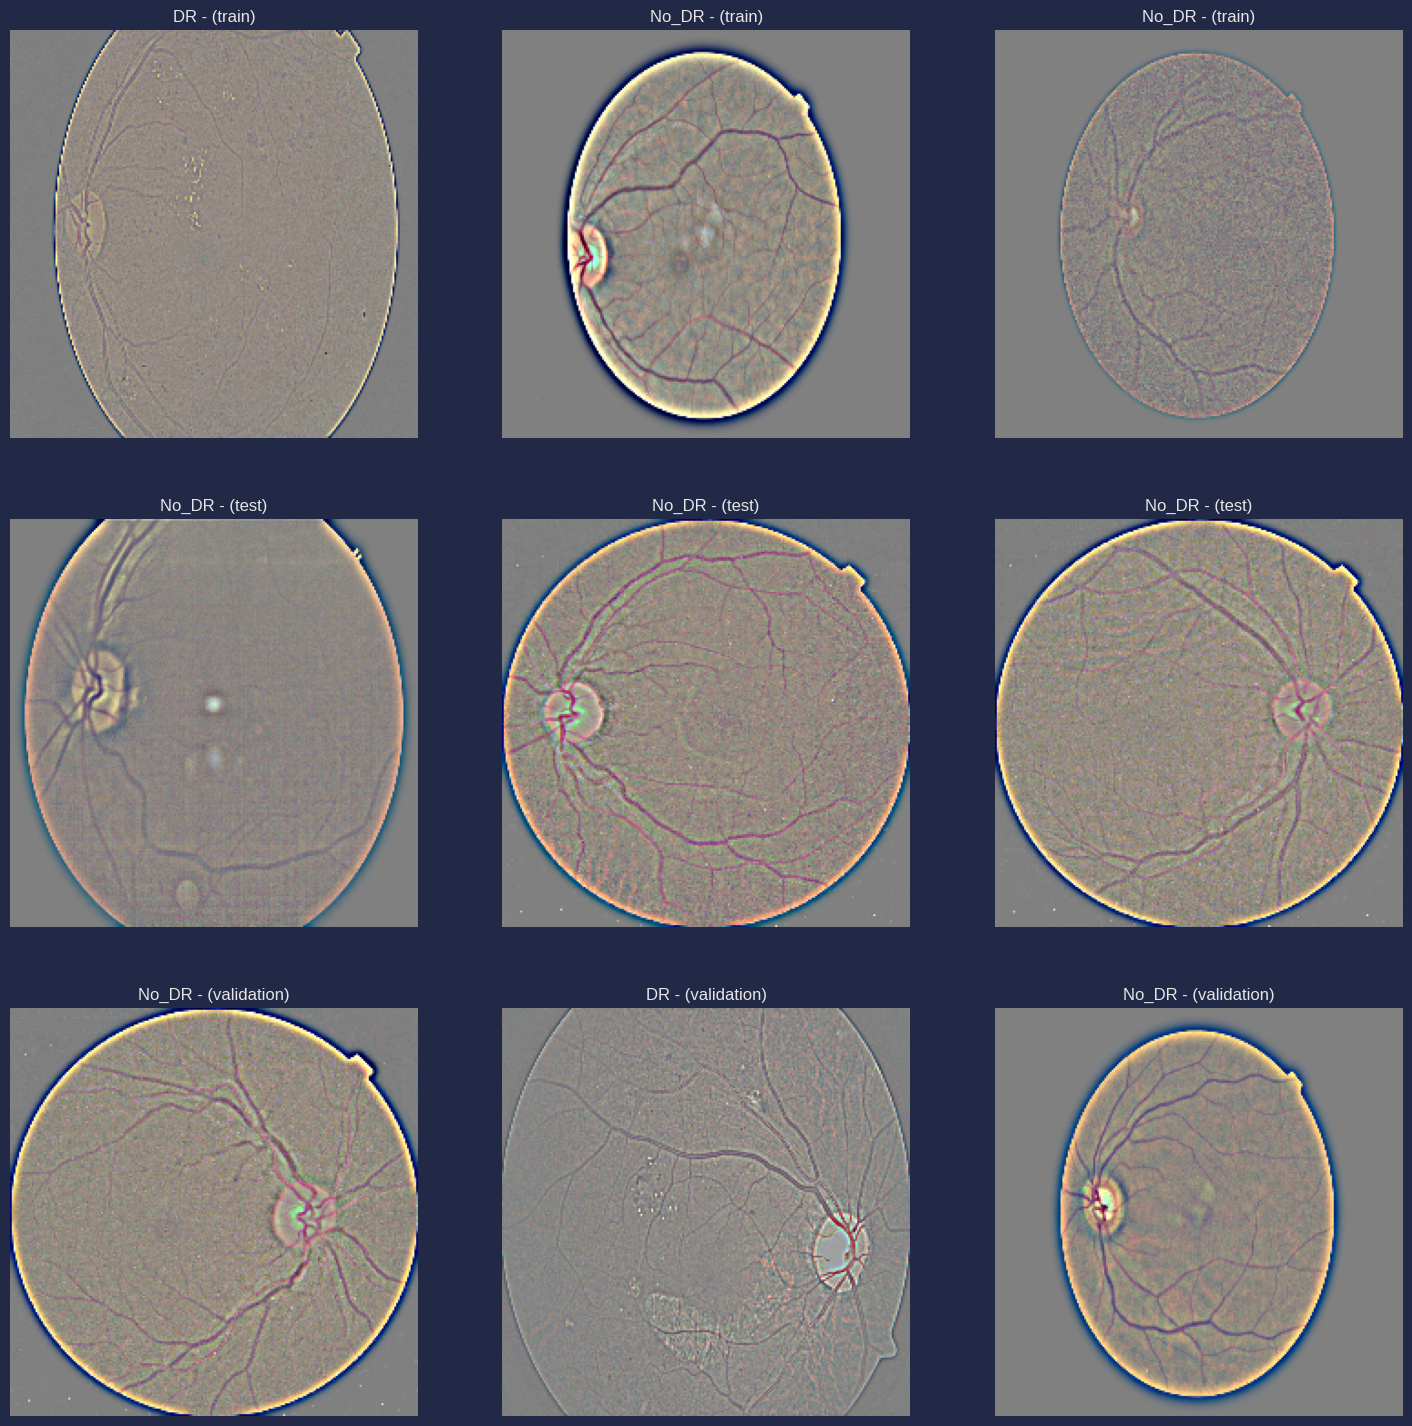

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18, 18), sharey='col')

for i, name, data_gen in [*zip(range(3), ['train', 'test', 'validation'], [train_data, test_data, val_data])]:
    for j in range(3):
        n_batch, n_image = np.random.randint(32), np.random.randint(data_gen.n//32)
        ax[i][j].imshow(
            train_data[n_image][0][n_batch]
        )
        label = np.argmax(train_data[n_image][1][n_batch])
        ax[i][j].set_title(f'{["DR", "No_DR"][label]} - ({name})')
        ax[i][j].axis('off')

In [ ]:
input_layer = tf.keras.layers.Input(shape = (224, 224, 3))

max_pool = tf.keras.layers.MaxPooling2D(pool_size = (3, 3))

conv2d1 = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = 'swish')
batch_norm1 = tf.keras.layers.BatchNormalization()

conv2d2 = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = 'swish')
batch_norm2 = tf.keras.layers.BatchNormalization()

conv2d3 = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = 'swish')
batch_norm3 = tf.keras.layers.BatchNormalization()

conv2d4 = tf.keras.layers.Conv2D(16, kernel_size = (3, 3), activation = 'swish')
batch_norm4 = tf.keras.layers.BatchNormalization()

flatten = tf.keras.layers.Flatten()

dense1 = tf.keras.layers.Dense(50, activation = 'swish')
dropout1 = tf.keras.layers.Dropout(.2)

predict = tf.keras.layers.Dense(2, activation = 'sigmoid')

x = input_layer

x = conv2d1(x)
x = max_pool(x)
x = batch_norm1(x)

x = conv2d2(x)
x = max_pool(x)
x = batch_norm2(x)

x = conv2d3(x)
x = max_pool(x)
x = batch_norm3(x)

x = flatten(x)
x = dense1(x)
x = dropout1(x)

model = tf.keras.Model(input_layer, predict(x))
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',           

In [ ]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()],
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
)

save_ck = callbacks.ModelCheckpoint('model_weights.hdf5',save_best_only=True,monitor='val_loss',mode='min'),

history = model.fit(
          train_data,
          epochs = 25,
          callbacks=[save_ck],
          validation_data = val_data
          )



Epoch 1/25
69/69 [==============================] - 30s 409ms/step - loss: 0.4946 - accuracy: 0.8128 - precision: 0.7657 - recall: 0.8156 - val_loss: 0.7195 - val_accuracy: 0.5073 - val_precision: 0.5073 - val_recall: 0.5073
Epoch 2/25
69/69 [==============================] - 27s 395ms/step - loss: 0.2985 - accuracy: 0.8775 - precision: 0.8730 - recall: 0.8798 - val_loss: 0.7837 - val_accuracy: 0.5073 - val_precision: 0.5073 - val_recall: 0.5073
Epoch 3/25
69/69 [==============================] - 27s 397ms/step - loss: 0.2545 - accuracy: 0.9048 - precision: 0.9019 - recall: 0.8998 - val_loss: 0.9968 - val_accuracy: 0.5073 - val_precision: 0.5073 - val_recall: 0.5073
Epoch 4/25
69/69 [==============================] - 27s 395ms/step - loss: 0.2257 - accuracy: 0.9249 - precision: 0.9172 - recall: 0.9185 - val_loss: 1.2217 - val_accuracy: 0.5073 - val_precision: 0.5073 - val_recall: 0.5073
Epoch 5/25
69/69 [==============================] - 27s 397ms/step - loss: 0.2148 - accuracy: 0.9299

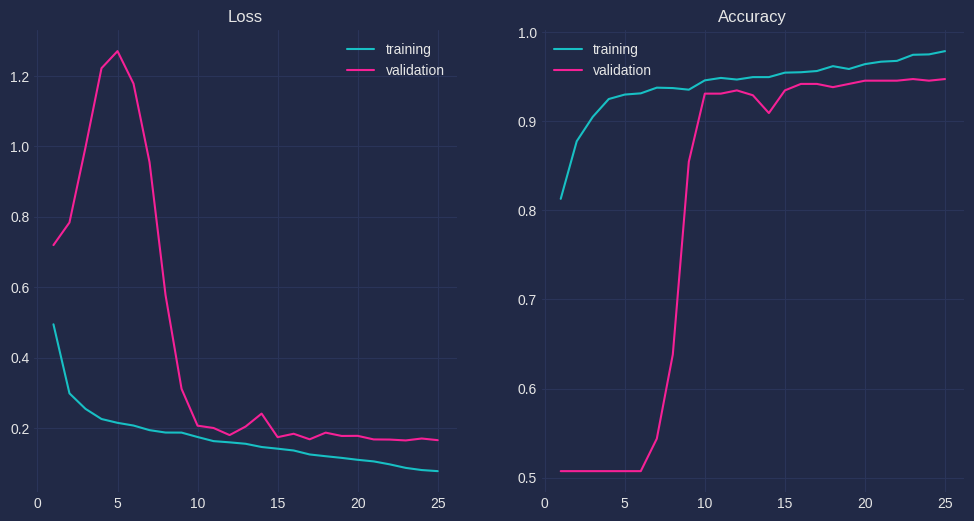

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
epochs = range(
    1,
    len(history.history['loss'])+1
)

ax[0].plot(
    epochs,
    history.history['loss'], 
    label='training'
)
ax[0].plot(
    epochs,
    history.history['val_loss'], 
    label='validation'
)
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(
    epochs,
    history.history['accuracy'],
    label='training'
)
ax[1].plot(
    epochs,
    history.history['val_accuracy'], 
    label='validation'
)
ax[1].set_title('Accuracy')
ax[1].legend()

In [ ]:
model.evaluate(test_data)

29/29 [==============================] - 4s 140ms/step - loss: 0.1509 - accuracy: 0.9574 - precision: 0.9531 - recall: 0.9541


[0.15087033808231354,
 0.9574235677719116,
 0.9531079530715942,
 0.9541484713554382]

In [ ]:
# !streamlit run trial.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8502
  External URL: http://34.94.52.123:8502

npx: installed 22 in 1.522s
your url is: https://beige-ways-roll-34-94-52-123.loca.lt


In [ ]:
import streamlit_lottie

In [ ]:
%%writefile trial.py
import streamlit as st
import time
import requests
import cv2
import webbrowser
import numpy as np
from streamlit_lottie import st_lottie
from streamlit_option_menu import option_menu
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2,preprocess_input as mobilenet_v2_preprocess_input

st.set_page_config(layout = "wide")

page = st.sidebar.selectbox('Select page',
  ['Home page','Predictor','Q&A','Infographics'])

def load_lottieurl(url):
        r = requests.get(url)
        if r.status_code != 200:
            return None
        return r.json()

if page == 'Home page':
    left_column,middle_column,right_column = st.columns(3)
    with middle_column:
      st.title("Diabetic Retinopathy Project")
    lottie_coding_eye = load_lottieurl("https://assets6.lottiefiles.com/packages/lf20_xa0q7ly3.json")
    
    with st.container():
        st.write("---")
        with middle_column:
            
            st_lottie(lottie_coding_eye, height=300, key="coding_eye")
    
    with left_column:
      with st.container():
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.title("PREDICTOR")
        st.write("A custom CNN model trained with over 3500 images gives predictions on the uploaded retinal image of any size if it is healthy or has a diabetic retinopathy condition with approximately an accuracy of 95%")
        lottie_coding_mini = load_lottieurl("https://assets5.lottiefiles.com/packages/lf20_KS2VTJka6L.json")
        st_lottie(lottie_coding_mini, height=200, key="brain")
        
    with middle_column:
      with st.container():
        st.write(" ")
        st.title("FAQs")
        st.write("Answers to all the frequently asked questions on the topic of diabetic retinopathy have been diligently curated from verified healthcare sources.")
        lottie_coding_tabs = load_lottieurl("https://assets6.lottiefiles.com/packages/lf20_au4zdsr8.json")
        st_lottie(lottie_coding_tabs, height=200, key="text")
    with right_column:
      with st.container():
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.write(" ")
        st.title("INFOGRAPHICS")
        st.write("Some crucial statistical plots have been collected to give the user an idea of how severe and widescale this condition is on a national and global scale.")
        lottie_coding_stats = load_lottieurl("https://assets8.lottiefiles.com/packages/lf20_r7h02cq4.json")
        st_lottie(lottie_coding_stats, height=200, key="stat")
if page == 'Predictor':
                st.title("Diabetic Retinopathy Predictor")
                lottie_coding_pred = load_lottieurl("https://assets1.lottiefiles.com/packages/lf20_wusrjror.json")
                left_column,middle_column,right_column = st.columns(3)
                with middle_column:
                    st_lottie(lottie_coding_pred, height=300, key="pred")
                if "uploaded_file" not in st.session_state:
                    st.session_state["uploaded_file"] = ""
                model = tf.keras.models.load_model("model_weights.hdf5")
                uploaded_file = st.file_uploader("Upload an image")
                
                map_dict = {0: 'DR',
                            1: 'No_DR'
                            }

                st.session_state["uploaded_file"] = uploaded_file
                
                if uploaded_file is not None:
                    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
                    opencv_image = cv2.imdecode(file_bytes, 1)
                    opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
                    resized = cv2.resize(opencv_image,(224,224))
                        # Now do something with the image! For example, let's display it:
                    st.image(opencv_image, channels="RGB")
                    st.success("Photo uploaded successfully !!!")

                    resized = mobilenet_v2_preprocess_input(resized)
                    img_reshape = resized[np.newaxis,...]

                    Genrate_pred = st.button("Generate Prediction",key="actual_pred")
                    if Genrate_pred:
                              prediction = model.predict(img_reshape).argmax()
                              st.title("Predicted Label for the image is {}".format(map_dict[prediction]))

if page == 'Q&A':
      left_column,right_column = st.columns(2)
      
      with left_column:
          st.title(" Q&A Section ")
          with st.expander("What is diabetic retinopathy?"):
              st.write("Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye. If you have diabetes, it’s important to get a comprehensive dilated eye exam at least once a year. Diabetic retinopathy may not have any symptoms at first — but finding it early can help you take steps to protect your vision. ")
              st.video("https://youtu.be/JxMOsMDM1UM")
          with st.expander("What are the symptoms of diabetic retinopathy?"):
              st.write("The early stages of diabetic retinopathy usually don’t have any symptoms. Some people notice changes in their vision, like trouble reading or seeing faraway objects. These changes may come and go. In later stages of the disease, blood vessels in the retina start to bleed into the vitreous (gel-like fluid that fills your eye). If this happens, you may see dark, floating spots or streaks that look like cobwebs. Sometimes, the spots clear up on their own — but it’s important to get treatment right away. Without treatment, scars can form in the back of the eye. Blood vessels may also start to bleed again, or the bleeding may get worse. ")
          with st.expander("Am I at risk for diabetic retinopathy?"):
              st.write("Anyone with any kind of diabetes can get diabetic retinopathy — including people with type 1, type 2, and gestational diabetes (a type of diabetes that can develop during pregnancy. Your risk increases the longer you have diabetes. Over time, more than half of people with diabetes will develop diabetic retinopathy. The good news is that you can lower your risk of developing diabetic retinopathy by controlling your diabetes. Women with diabetes who become pregnant — or women who develop gestational diabetes — are at high risk for getting diabetic retinopathy. If you have diabetes and are pregnant, have a comprehensive dilated eye exam as soon as possible. Ask your doctor if you’ll need additional eye exams during your pregnancy. ")
          with st.expander("What causes diabetic retinopathy?"):
              st.write("Diabetic retinopathy is caused by high blood sugar due to diabetes. Over time, having too much sugar in your blood can damage your retina — the part of your eye that detects light and sends signals to your brain through a nerve in the back of your eye. Diabetes damages blood vessels all over the body. The damage to your eyes starts when sugar blocks the tiny blood vessels that go to your retina, causing them to leak fluid or bleed. To make up for these blocked blood vessels, your eyes then grow new blood vessels that don’t work well. These new blood vessels can leak or bleed easily. ")
          with st.expander("How will my eye doctor check for diabetic retinopathy?"):
              st.write("Eye doctors can check for diabetic retinopathy as part of a dilated eye exam. The exam is simple and painless — your doctor will give you some eye drops to dilate (widen) your pupil and then check your eyes for diabetic retinopathy and other eye problems. If your eye doctor thinks you may have severe diabetic retinopathy or DME, they may do a test called a fluorescein angiogram. This test lets the doctor see pictures of the blood vessels in your retina.")
          with st.expander("What can I do to prevent diabetic retinopathy?"):
              st.write("Managing your diabetes is the best way to lower your risk of diabetic retinopathy. That means keeping your blood sugar levels in a healthy range. You can do this by getting regular physical activity, eating healthy, and carefully following your doctor’s instructions for your insulin or other diabetes medicines. To make sure your diabetes treatment plan is working, you’ll need a special lab test called an A1C test. This test shows your average blood sugar level over the past 3 months. You can work with your doctor to set a personal A1C goal. Meeting your A1C goal can help prevent or manage diabetic retinopathy. Having high blood pressure or high cholesterol along with diabetes increases your risk for diabetic retinopathy. So controlling your blood pressure and cholesterol can also help lower your risk for vision loss.")
          with st.expander("What’s the treatment for diabetic retinopathy and DME?"):
              st.write("In the early stages of diabetic retinopathy, your eye doctor will probably just keep track of how your eyes are doing. Some people with diabetic retinopathy may need a comprehensive dilated eye exam as often as every 2 to 4 months.")
              st.write("In later stages, it’s important to start treatment right away — especially if you have changes in your vision. While it won’t undo any damage to your vision, treatment can stop your vision from getting worse. It’s also important to take steps to control your diabetes, blood pressure, and cholesterol.")
              st.write("Injections : Medicines called anti-VEGF drugs can slow down or reverse diabetic retinopathy. Other medicines, called corticosteroids, can also help.")
              st.write("Laser treatment : To reduce swelling in your retina, eye doctors can use lasers to make the blood vessels shrink and stop leaking.")
              st.write("Eye surgery : If your retina is bleeding a lot or you have a lot of scars in your eye, your eye doctor may recommend a type of surgery called a vitrectomy.")
          with st.expander("How Are Eye Injections Done?"):
              st.video("https://youtu.be/esZTnQQpJTo")
          with st.expander("What is Vitrectomy Surgery?"):
              st.video("https://youtu.be/5-XY-_AwBMs")
          with st.expander("What is the latest research on diabetic retinopathy and DME?"):
              st.write("Scientists are studying better ways to find, treat, and prevent vision loss in people with diabetes. One NIH-funded research team is studying whether a cholesterol medicine called fenofibrate can stop diabetic retinopathy from getting worse.")
          
      with right_column:
    
          lottie_coding_qna = load_lottieurl("https://assets9.lottiefiles.com/packages/lf20_zntl98s1.json")
          st_lottie(lottie_coding_qna, height=700, key="qna")

if page == 'Infographics':
      st.title(" Infographics ")
      left_column,right_column = st.columns(2)
     
      with left_column:
        with st.expander("Points to keep in mind"):
          st.image("/content/Screenshot 2023-04-07 at 3.34.54 PM 2.png")
        with st.expander("Global Diabetic Retinopathy Market Share"):
          st.image("/content/Marketshare.jpeg")
        with st.expander("Global prevalence of Diabetic Retinopathy"):
          st.image("/content/Globalprevalence.jpeg")
        with st.expander("Global Diabetic Retinopathy Drugs Market"):
          st.image("/content/Drugsmarket.jpeg")
          
      with right_column:
          lottie_coding_info = load_lottieurl("https://assets7.lottiefiles.com/packages/lf20_22mjkcbb.json")
          st_lottie(lottie_coding_info, height=500, key="info")



Overwriting trial.py
